## INTRODUCTION TO STARS CLASSIFICATION

WELCOME to this notebook!

The aim of this work is to find a way to classify the different types of stars defined in the **Hertzsprung-Russel diagram** (shown here below). This graph is a scatter plot of stars showing the relationship between the stars' absolute magnitudes or luminosities versus their stellar classifications or effective temperatures. You can find a more detailed description of this graph [here](https://en.wikipedia.org/wiki/Hertzsprung%E2%80%93Russell_diagram). 


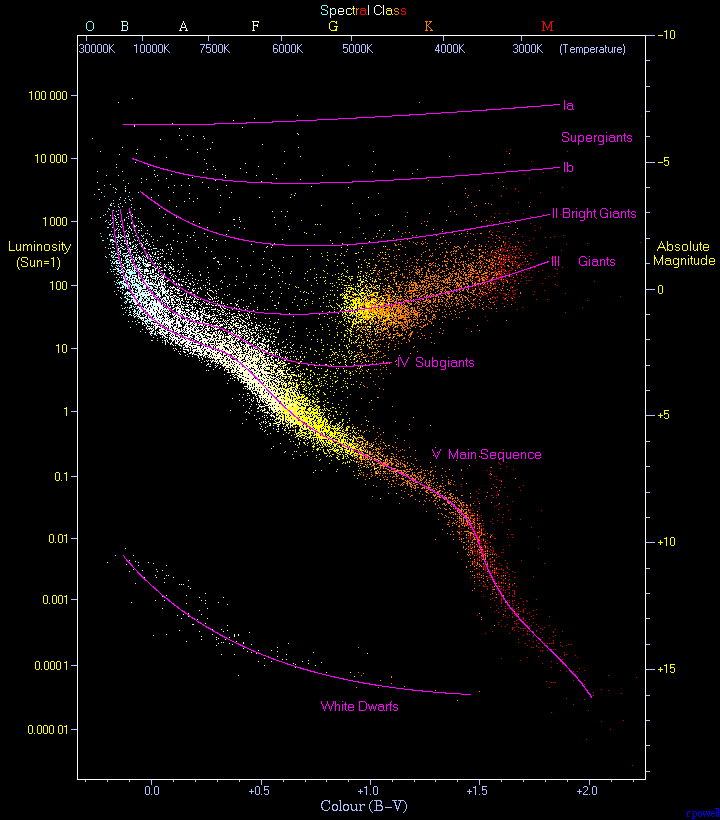

Let's start importing all the libraries necessary to complete the project! 

In [ ]:
# IMPORTING LIBRARIES & MAIN PATH

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew, norm

%matplotlib inline

import warnings
warnings.filterwarnings(action="ignore")


In [ ]:
# IMPORTING and INVESTIGATING DATA

stars_data = pd.read_csv('../input/star-type-classification/Stars.csv')
stars_data.info()

In [ ]:
# Let's take a look at our data

stars_data.head()

In [ ]:
# Looking for duplicates

stars_data.duplicated().sum()

No duplicated observations are present in our dataset. What about missing values (**Nan**)?

In [ ]:
# Looking at NaN % within the data

nan = pd.DataFrame(stars_data.isna().sum(), columns = ['NaN_sum'])
nan['feat'] = nan.index
nan['Perc(%)'] = (nan['NaN_sum']/1460)*100
nan = nan[nan['NaN_sum'] > 0]
nan = nan.sort_values(by = ['NaN_sum'])
nan['Usability'] = np.where(nan['Perc(%)'] > 20, 'Discard', 'Keep')
nan

WoW, no missing data are present either! Ok, now that we have controlled our dataset for duplicates and missing values we need to know something more about the classes that we need to discriminate:

In [ ]:
# Among how many classes do we have to discriminate ?

stars_type = ['Red Dwarf','Brown Dwarf','White Dwarf','Main Sequence','Super Giants','Hyper Giants']
stars_data['Class'] =  stars_data['Type'].replace(stars_data['Type'].unique(),stars_type)
print(stars_data['Class'].unique())

In [ ]:
# Are the classes balanced ?

sns.set_theme('paper')
plt.figure(figsize = (10,5))
sns.countplot(x='Class', data = stars_data)
plt.title("Classes' distribution across data", fontsize = 14)
plt.xlabel(' ', fontsize = 12)
plt.ylabel('Class Frequency (n)', fontsize = 12)
plt.show()

Definitely YES! Our classes are equally distributed among the data 🦾. Now we can make some considerations about our dataset and the single features that compose it.

## General data considerations:

As we can see, the dataset is quite small (240 observations); this should reduce our probabilities to obtain robust results (at least at the scientific level). Nevertheless, the data are already enough to get an idea of which are the main features used by different algorithms to achieve the task.


## Features Description:

numerical features:

- **Temperature**  (Kelvin)
- **Main-sequence luminosity**  (L - Solar luminosity)
- **Main-sequence radius**  (R - Solar radius)
- **Absolute Magnitute**  (AM - is a measure of the luminosity of a celestial object, on an inverse logarithmic astronomical magnitude scale)

and categorical features:
- **Color**
- **Spectral Class**  (*Morgan–Keenan* (MK) system using the letters: O (hottest),B,A,F,G,K,M (coldest))
- **Type**  (Red Dwarf, Brown Dwarf, White Dwarf, Main Sequence , Super Giants, Hyper Giants)



In [ ]:
# Color feature correction

stars_data['Color'].loc[stars_data['Color'] =='Blue-white'] = 'Blue-White'
stars_data['Color'].loc[stars_data['Color'] =='Blue White'] = 'Blue-White'
stars_data['Color'].loc[stars_data['Color'] =='Blue white'] = 'Blue-White'
stars_data['Color'].loc[stars_data['Color'] =='yellow-white'] = 'White-Yellow'
stars_data['Color'].loc[stars_data['Color'] =='Yellowish White'] = 'White-Yellow'
stars_data['Color'].loc[stars_data['Color'] =='white'] = 'White'
stars_data['Color'].loc[stars_data['Color'] =='yellowish'] = 'Yellowish'

Looking carefully into the dataset we can see that the '*Color*' feature contains different spelling errors that define more colors than we have. I used the snippet of the code above to correct them.

## EXPLORATORY DATA ANALYSIS (EDA) 📊

Let's take a look at the properties of our numerical variables:

In [ ]:
# Let's look at the descriptive statistics

stars_data.describe()

In [ ]:
# Looking at our numerical features' ditributions

f, ax = plt.subplots(1,4, figsize = (20,6))

sns.distplot(stars_data['Temperature'],fit=norm, color='#FB8861', ax = ax[0])
ax[0].set_title('Temperature \n Normal dist.', fontsize=14)

sns.distplot(stars_data['L'],fit=norm, color='#C5B3F9', ax = ax[1])
ax[1].set_title('Main-sequence luminosity \n Normal dist.', fontsize=14)

sns.distplot(stars_data['R'],fit=norm,color='g', ax = ax[2])
ax[2].set_title('Main-sequence radius \n Normal dist.', fontsize=14)

sns.distplot(stars_data['A_M'],fit=norm, color='y', ax = ax[3])
ax[3].set_title('Absolute Magnitute \n Normal dist.', fontsize=14)

plt.show()

In [ ]:
# Looking at our numerical features' descriptive aspects 
f, ax = plt.subplots(2,2, figsize = (20,15))

sns.boxplot(x = stars_data['Class'], y = stars_data['Temperature'], color='#FB8861', ax = ax[0][0])
ax[0][0].set_title('Temperature by Class', fontsize=14)
ax[0][0].set_xlabel(' ')

sns.boxplot(x = stars_data['Class'], y = stars_data['L'], color='#C5B3F9', ax = ax[0][1])
ax[0][1].set_title('Main-sequence luminosity by Class', fontsize=14)
ax[0][1].set_xlabel(' ')

sns.boxplot(x = stars_data['Class'], y = stars_data['R'], color='g', ax = ax[1][0])
ax[1][0].set_title('Main-sequence radius by Class', fontsize=14)
ax[1][0].set_xlabel(' ')

sns.boxplot(x = stars_data['Class'], y = stars_data['A_M'], color='y', ax = ax[1][1])
ax[1][1].set_title('Absolute Magnitute by Class', fontsize=14)
ax[1][1].set_xlabel(' ')

plt.show()

In [ ]:
# Correlation Heatmaps (Pearson - Spearman)

f, ax = plt.subplots(1,2, figsize=(15, 15))

mat_p = stars_data.drop('Type', axis = 1).corr('pearson')
mat_s = stars_data.drop('Type', axis = 1).corr('spearman')

mask_p = np.triu(np.ones_like(mat_p, dtype=bool))
mask_s = np.triu(np.ones_like(mat_s, dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(mat_p, mask=mask_p, cmap=cmap, vmax=1, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},ax = ax[0])
ax[0].set_title('Correlation Heatmap (Pearson)', fontsize = 14)

sns.heatmap(mat_s, mask=mask_s, cmap=cmap, vmax=1, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},ax = ax[1])
ax[1].set_title('Correlation Heatmap (Spearman)', fontsize = 14)

plt.show()

In [ ]:
# Let's look at the scatterplots

sns.pairplot(data=stars_data,hue="Type")
plt.show()

In [ ]:
# Outliers removal function

def outliers_removal(feature,feature_name,dataset):
    
    # Identify 25th & 75th quartiles

    q25, q75 = np.percentile(feature, 25), np.percentile(feature, 75)
    print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
    feat_iqr = q75 - q25
    print('iqr: {}'.format(feat_iqr))
    
    feat_cut_off = feat_iqr * 1.5
    feat_lower, feat_upper = q25 - feat_cut_off, q75 + feat_cut_off
    print('Cut Off: {}'.format(feat_cut_off))
    print(feature_name +' Lower: {}'.format(feat_lower))
    print(feature_name +' Upper: {}'.format(feat_upper))
    
    outliers = [x for x in feature if x < feat_lower or x > feat_upper]
    print(feature_name + ' number of outliers deleted: {}'.format(len(outliers)))
    #print(feature_name + ' outliers:{}'.format(outliers))

    dataset = dataset.drop(dataset[(dataset[feature_name] > feat_upper) | (dataset[feature_name] < feat_lower)].index)
    print('-' * 65)
    
    return dataset


data_cleaned = outliers_removal(stars_data['L'],'L', stars_data)

In [ ]:
# Separating numerical from categorical variables

num_feat = stars_data.drop(['Color','Spectral_Class','Type','Class'], axis = 1)
cat_feat = stars_data.drop(['Temperature','L','R','A_M','Type','Class'], axis = 1)

In [ ]:
# Getting dummy variables

data_dummy = pd.get_dummies(cat_feat)
data_dummy.head()

In [ ]:
# Scaling

from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(num_feat)
data_scaled = pd.DataFrame(data_scaled, columns = num_feat.columns)
data_scaled.head()

In [ ]:
# Crating our final train dataframe

data_complete = data_scaled.join(data_dummy)
data_complete.head()

In [ ]:
# Splitting the data into Train & Test sets

from sklearn.model_selection import train_test_split

# Defining our labels

labels = stars_data['Class']

# Splitting the data

Xtrain,X_test,ytrain,y_test = train_test_split(data_complete,labels,
                                               test_size = 0.1,
                                               stratify = labels,
                                               shuffle = True)


X_train,X_val,y_train,y_val = train_test_split(Xtrain,ytrain,
                                               test_size = 0.1,
                                               stratify = ytrain,
                                               shuffle = True)

In [ ]:
# Machine Learning Libraries

import sklearn
from sklearn import tree
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report

In [ ]:
# LOGISTIC REGRESSION

l_reg = LogisticRegression(random_state = 42)
log_model = l_reg.fit(X_train,y_train)
pred = log_model.predict(X_val)

print(classification_report(y_val, pred , target_names = stars_data['Class'].unique()))

In [ ]:
# RANDOM FOREST CLASSIFIER

rf = RandomForestClassifier(random_state = 42)
rf_model = rf.fit(X_train,y_train)
pred_rf = rf_model.predict(X_val)

print(classification_report(y_val, pred_rf , target_names = stars_data['Class'].unique()))

## EVALUATION

In [ ]:
# Looking at feature importance

importance_rf = rf_model.feature_importances_
feat_names = list(zip(importance_rf, X_train.columns))

# summarize feature importance
for i,v in enumerate(importance_rf):
    #print('Feature: %0d, Score: %.5f' % (i,v))
    print(str(feat_names[i][1]) +': '+ '%.5f' % (v))

In [ ]:
# Plotting feature importance

plt.figure(figsize = (15,7))
sns.barplot(y = X_train.columns, x = importance_rf, orient = 'h')
plt.title('Random Forest Features importance', fontsize = 14)
plt.xlabel('Importance', fontsize = 12)
plt.show()

Looking at the plot we can clearly see that **Absolute Magnitude, Main_sequence Radius, Main_sequence Luminosity and Temperature** are the ones with the highest level of importance. These are the features with the highest weight in the final classification. Now, let's investigate more in detail how an estimator reaches the final decision:

In [ ]:
from IPython.display import Image
from subprocess import call
from sklearn.tree import export_graphviz

estimator = rf_model.estimators_[5]

export_graphviz(estimator, 
                out_file='tree.dot', 
                feature_names = X_train.columns,
                class_names = stars_data['Class'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
Image(filename = 'tree.png')

**Still under processing...**